In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
##########################
save_history = False # if true, updates portfolio and platform history files. if false, only updates if there is no record of the current month already in the portfolio history.
##########################
today = pd.to_datetime('today').normalize()
loans_df = pd.read_csv('data/concatenated.csv')
cash_df = pd.read_csv('data/cash.csv', index_col='platform_account_name')
portfolio_df = pd.read_csv('data/portfolio_history.csv', index_col=0, parse_dates=[0])
platform_dict = { 'loanpad':'Loanpad 60d Access','proplend':'Proplend','crowdproperty':'CrowdProperty AutoInvest','invest_fund':'Invest & Fund','assetz_capital':'Assetz Capital 90d Access','kuflink':'Kuflink 24m Term 28133' }
col_list = ['Int bearing amt','Non-IB cash','Total amt','No loans','Avg loan amt','Avg net AER','Blended LTV','Avg term','Max term','Avg ttm','Max ttm','Non-perform','Long default','Short default','Int default']
platform_totals_list = [loans_df['loan_part_amt'].sum() + cash_df['ib_cash'].sum(),cash_df['nonib_cash'].sum(),loans_df['loan_part_amt'].sum() + cash_df['ib_cash'].sum() + cash_df['nonib_cash'].sum(),loans_df['loan_portion'].sum(),loans_df['loan_part_amt'].sum() / loans_df['loan_portion'].sum(),loans_df['portfolio_weighted_net_aer'].sum(),loans_df['portfolio_weighted_blended_ltv'].sum(),loans_df['portfolio_weighted_term_months'].sum(),loans_df['loan_part_term_months'].max(),loans_df['portfolio_weighted_ttm_months'].sum(),loans_df['loan_part_ttm_days'].max()/33.437,loans_df.loc[loans_df['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum(), loans_df.loc[loans_df['platform_account_sector'] == 'Development']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['platform_account_sector'] == 'Commercial']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),len(platform_dict),loans_df['loan_part_amt'].sum() / len(platform_dict)]
format_dict = { 'Int bearing amt': '£{0:,.2f}','Non-IB cash': '£{0:,.2f}','Total amt': '£{0:,.2f}','No loans': '{:,.0f}','Avg loan amt': '£{0:,.2f}','Blended LTV': '{:,.0%}','Avg net AER': '{:,.1%}','Avg term': '{:,.0f}','Max term': '{:,.0f}','Avg ttm': '{:,.0f}','Max ttm': '{:,.0f}','Non-perform': '{:,.0%}','Long default': '£{0:,.0f}','Short default': '£{0:,.0f}','Int default': '£{0:,.0f}','Dev sector': '{:.0%}', 'Comm sector': '{:.0%}','No a/c': '{:,.0f}','Avg a/c amt': '£{0:,.0f}'}
colours_list = ['green','blue','red','orange','purple','pink']
if portfolio_df.iloc[-1].name.month < pd.to_datetime('today').month: # flip save_history to true if there is no record of current month in portfolio history
    save_history = True
def save_platform_csv(platform): # function to update platform_history.csv for all platform accounts
    exec(platform + "_df = pd.read_csv('data/" + platform + "_history.csv', index_col=0, parse_dates=[0])")
    platform_account = platform_dict[platform]
    platform_loans = loans_df.loc[loans_df['platform_account_name'] == platform_account]
    platform_ib_cash = cash_df.loc[platform_account]['ib_cash']
    platform_nonib_cash = cash_df.loc[platform_account]['nonib_cash']
    platform_deployed_amt = platform_loans['loan_part_amt'].sum() + platform_ib_cash
    platform_total_amt = platform_deployed_amt + platform_nonib_cash
    exec(platform + "_df.loc[today] = [platform_deployed_amt,platform_nonib_cash,platform_total_amt,platform_loans['loan_portion'].sum(),platform_loans['loan_part_amt'].sum() / platform_loans['loan_portion'].sum(),platform_loans['platform_weighted_net_aer'].sum(),platform_loans['platform_weighted_blended_ltv'].sum(),platform_loans['platform_weighted_term_months'].sum(),platform_loans['loan_part_term_months'].max(),platform_loans['platform_weighted_ttm_months'].sum(),platform_loans['loan_part_ttm_days'].max()/33.437,platform_loans.loc[platform_loans['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / loans_df.loc[loans_df['platform_account_name'] == platform_account, 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum()]")
    exec(platform + "_df.to_csv('data/" + platform + "_history.csv', index=True)")

### Platforms

In [3]:
platform_df = pd.DataFrame(columns=col_list)
for platform_account in platform_dict.values():
    platform_loans = loans_df.loc[loans_df['platform_account_name'] == platform_account]
    platform_ib_cash = cash_df.loc[platform_account]['ib_cash']
    platform_nonib_cash = cash_df.loc[platform_account]['nonib_cash']
    platform_deployed_amt = platform_loans['loan_part_amt'].sum() + platform_ib_cash
    platform_total_amt = platform_deployed_amt + platform_nonib_cash
    platform_df.loc[platform_account] =  [platform_deployed_amt,platform_nonib_cash,platform_total_amt,platform_loans['loan_portion'].sum(),platform_loans['loan_part_amt'].sum() / platform_loans['loan_portion'].sum(),platform_loans['platform_weighted_net_aer'].sum(),platform_loans['platform_weighted_blended_ltv'].sum(),platform_loans['platform_weighted_term_months'].sum(),platform_loans['loan_part_term_months'].max(),platform_loans['platform_weighted_ttm_months'].sum(),platform_loans['loan_part_ttm_days'].max()/33.437,platform_loans.loc[platform_loans['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / loans_df.loc[loans_df['platform_account_name'] == platform_account, 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum()]
if save_history == True:
    for platform in platform_dict.keys():
        save_platform_csv(platform) # function to update platform_history.csv for all platform accounts
platform_df.style.format(format_dict)

,Int bearing amt,Non-IB cash,Total amt,No loans,Avg loan amt,Avg net AER,Blended LTV,Avg term,Max term,Avg ttm,Max ttm,Non-perform,Long default,Short default,Int default
Loanpad 60d Access,"£5,340.00",£2.74,"£5,342.74",176,£29.23,6.5%,43%,2,2,2,2,2%,£0,£0,£127
Proplend,"£3,000.00",£9.79,"£3,009.79",3,"£1,000.00",6.7%,50%,28,36,19,32,0%,£0,£0,£0
CrowdProperty AutoInvest,"£2,053.02",£10.39,"£2,063.41",33,£62.21,7.9%,66%,14,21,6,14,27%,£100,£448,£0
Invest & Fund,"£2,183.81",£417.09,"£2,600.90",16,£136.49,7.0%,66%,12,24,6,15,0%,£0,£0,£0
Assetz Capital 90d Access,£821.67,£0.00,£821.67,224,£3.67,4.1%,61%,50,78,20,48,15%,£22,£31,£73
Kuflink 24m Term 28133,"£1,049.97",£0.00,"£1,049.97",100,£10.50,8.0%,64%,24,24,20,18,8%,£0,£0,£85


### Portfolio

In [4]:
portfolio_df.loc[today] = platform_totals_list
if save_history == True:
    portfolio_df.to_csv('data/portfolio_history.csv', index=True)
portfolio_df.sort_index(ascending=False).style.format_index(lambda s: s.strftime('%Y-%m')).format(format_dict)
#risk premiums over Gilts & deposits

,Int bearing amt,Non-IB cash,Total amt,No loans,Avg loan amt,Avg net AER,Blended LTV,Avg term,Max term,Avg ttm,Max ttm,Non-perform,Long default,Short default,Int default,Dev sector,Comm sector,No a/c,Avg a/c amt
2023-11,"£14,448.47",£440.01,"£14,888.48",552,£25.82,6.8%,54%,15,78,9,48,6%,£122,£479,£285,73%,27%,6,"£2,376"
2023-10,"£14,741.91",£89.84,"£14,831.75",559,£26.04,6.5%,53%,14,78,7,49,4%,£122,£333,£200,74%,26%,6,"£2,426"
2023-09,"£14,606.01",£410.19,"£15,016.20",588,£24.69,6.4%,54%,14,83,7,50,3%,£124,£118,£220,73%,27%,6,"£2,419"
2023-08,"£14,672.50",£119.50,"£14,792.00",596,£24.52,6.3%,54%,14,83,8,51,4%,£122,£270,£225,74%,26%,6,"£2,436"


[Text(5, 0, '£29.23'),
 Text(5, 0, '£1,000.00'),
 Text(5, 0, '£62.21'),
 Text(5, 0, '£136.49'),
 Text(5, 0, '£3.67'),
 Text(5, 0, '£10.50')]

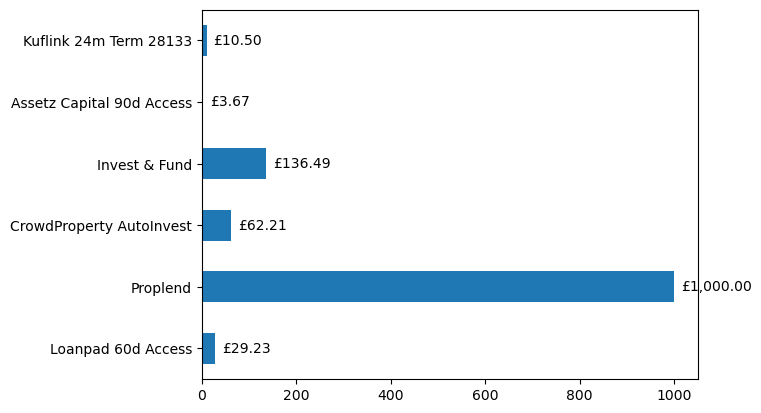

In [5]:
ax = platform_df.plot.barh(y='Avg loan amt', legend=False)
ax.bar_label(ax.containers[0], fmt='£{0:,.2f}', label_type='edge', padding=5)

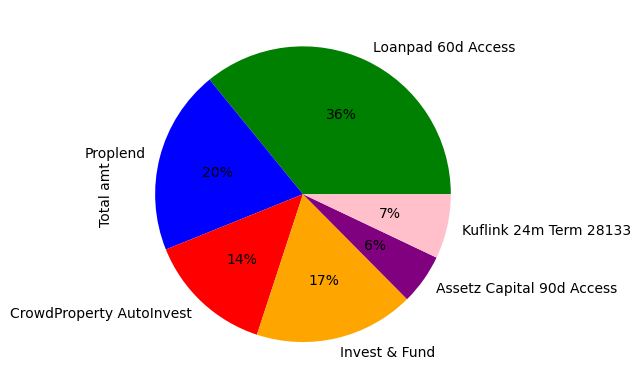

In [6]:
ax = platform_df['Total amt'].plot(kind='pie', colors=colours_list, autopct='%1.0f%%', legend=False)

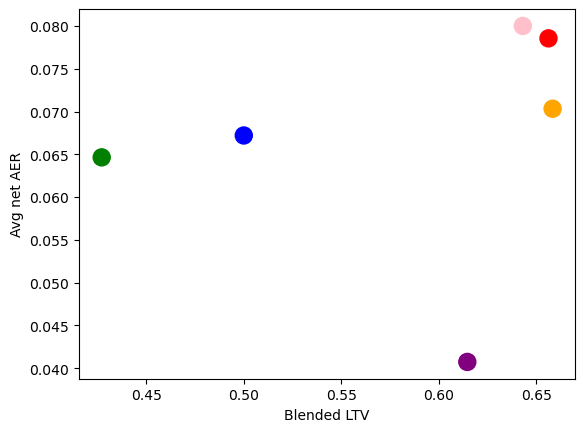

In [7]:
ax = platform_df.plot(kind='scatter', x='Blended LTV', y='Avg net AER', s=150, c=colours_list)